In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.TwitterGraphDataModule import TwitterGraphDataModule
import time
import torch
import torch_geometric

# config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 256

In [2]:

graph_type = TextGraphType.SENTIMENT
removals = [] # Enter node types to remove here
# removals = ['general'] # Without General Nodes
# removals = ['dep'] # Without Dependency Nodes
# removals = ['tag'] # Without Tag Nodes
# removals = ['sentiment'] # Without Sentiment Nodes
# removals = ['sentiment' , 'general'] # Without Sentiment and General Nodes
data_manager = TwitterGraphDataModule(config, True, True, shuffle=False, start_data_load=0 , end_data_load = 110000, device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True , removals=removals)
data_manager.load_labels()
data_manager.load_graphs()

filename: E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence\data/GraphData/Sentiment140\140_sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 110/110 [04:20<00:00,  2.37s/it]


In [ ]:
data_manager.graph_constructors[TextGraphType.SENTIMENT].get_first()

In [3]:
# data_manager.update_batch_size(128)
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))

In [4]:
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear
from Scripts.Models.GraphNodeEmbedding.HeteroDeepGraphNodeEmbedding1 import HeteroDeepGraphNodeEmbedding1
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding1 import HeteroDeepGraphEmbedding1
from Scripts.Models.GraphEmbedding.HeteroMempool1 import HeteroMempool1

In [5]:
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLossArgs, HeteroLoss1, HeteroLoss2
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [6]:
graph_embedding = HeteroDeepGraphEmbedding1(300, 1, X1.metadata(), 128, dropout=0.2, edge_type_count=11)
graph_embedding = graph_embedding.to(device)

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [7]:
# lightning_model = HeteroBinaryLightningModel.load_from_checkpoint(r'C:\Users\fardin\Projects\ColorIntelligence\logs\hetero_model_5\version_0\checkpoints\epoch=7-step=2056.ckpt', model=)

# callbacks = [
#     ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
#     EarlyStopping(patience=50, mode='max', monitor='val_acc')
# ]
lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                 torch.optim.Adam(graph_embedding.parameters(), lr=0.004, weight_decay=0.001),
                                       loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.05),
                                       learning_rate=0.004,
                                       batch_size=batch_size,
                                       user_lr_scheduler=True,
                                       min_lr=0.00005
                                       ).to(device)
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_6', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_3',device=device, num_train_epoch=200)

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# model_manager.tune(data_manager=data_manager, min_lr=1e-7, max_lr = 1e-2)

In [8]:
model_manager.fit(datamodule=data_manager)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding1 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\li

Epoch 53:  41%|████      | 105/257 [00:36<00:53,  2.86it/s, v_num=14, train_acc_step=0.816, val_acc_step=0.804, val_acc_epoch=0.781, train_acc_epoch=0.792]

c:\Users\Omid\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [12]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

def evaluate(eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        model_manager.lightning_model.eval()
        for X, y in eval_dataloader:
            # print(f"ii: {X.edge_index_dict[('word', 'word_sentiment', 'sentiment')]}")
            y_p, _ = model_manager.torch_model(X.to(device))
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        # print(f"ii: {y_true.shape} : {y_pred.shape}")
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        if(give_hinge_loss):
            print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')

In [10]:
X3, y3 = next(iter(data_manager.test_dataloader()))

In [20]:
evaluate(data_manager.test_dataloader())

confusion_matrix: 
[[8562 2481]
 [2128 8829]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     11043
           1       0.78      0.81      0.79     10957

    accuracy                           0.79     22000
   macro avg       0.79      0.79      0.79     22000
weighted avg       0.79      0.79      0.79     22000



In [15]:
model_manager.trainer.save_checkpoint(r'C:\Users\Omid\Desktop\deep_graph_embedding_1_twitter.ckpt')

In [19]:
custom_model = HeteroBinaryLightningModel.load_from_checkpoint(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence\logs\hetero_model_6\version_14\checkpoints\epoch=39-step=10280.ckpt', model=graph_embedding)
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_6', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_3',device=device, num_train_epoch=200)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
test_dataloader = data_manager.test_dataloader()
x_t, y_t = next(iter(test_dataloader))
len(x_t)

256

In [18]:
custom_model.eval()
y_pred = custom_model(x_t.to(device))

In [ ]:
y_pred2 = (y_pred[0]>0).to(torch.int)
y_pred2 = y_pred2.to('cpu')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score, classification_report

In [ ]:
print(classification_report(y_t, y_pred2))

In [ ]:
confusion_matrix(y_t, y_pred2)

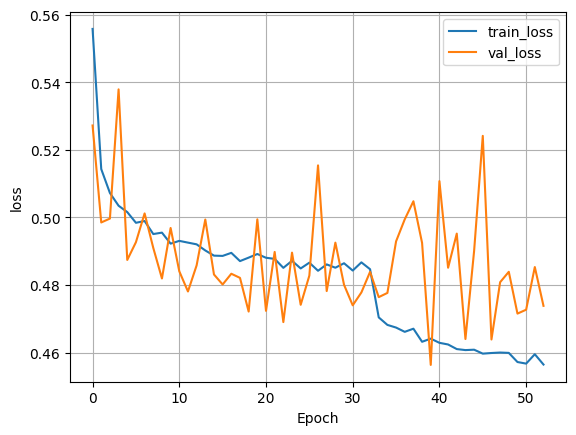

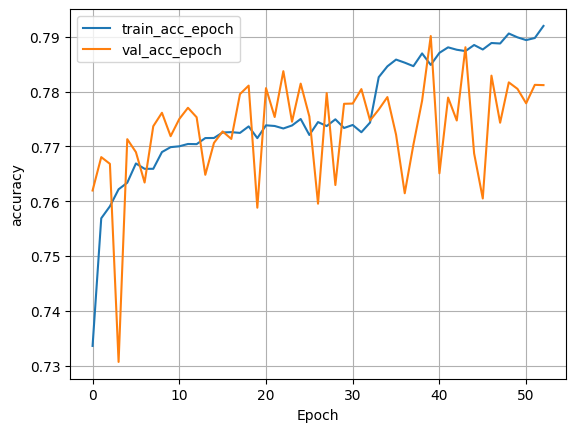

In [14]:
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])